In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))
import data_utils

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [4]:
df_train.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [5]:
df_train.dtypes.value_counts()

int64      30
float64     7
object      1
Name: count, dtype: int64

In [6]:
target_col = 'Target'
cont_features = df_train.dtypes[df_train.dtypes == "float"].index.values
cat_features = df_train.dtypes[df_train.dtypes == "int"].index.values

In [7]:
df_col_info = pd.DataFrame({
    "col_name": df_train.columns,
    "col_unique_count": df_train.nunique().values,
    "col_dtype": df_train.dtypes.values
})
df_col_info.sort_values("col_unique_count", ascending=False)

,col_name,col_unique_count,col_dtype
0,id,76518,int64
32,Curricular units 2nd sem (grade),1234,float64
26,Curricular units 1st sem (grade),1206,float64
13,Admission grade,668,float64
7,Previous qualification (grade),110,float64
12,Father's occupation,56,int64
20,Age at enrollment,46,int64
11,Mother's occupation,40,int64
10,Father's qualification,39,int64
24,Curricular units 1st sem (evaluations),36,int64


In [8]:
df_train.Target.value_counts()/df_train.shape[0]

Target
Graduate    0.474163
Dropout     0.330589
Enrolled    0.195248
Name: count, dtype: float64

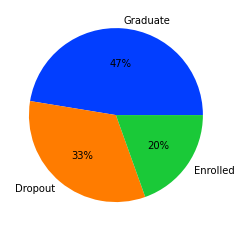

In [9]:
# define Seaborn color palette to use 
palette_color = sns.color_palette('bright') 
  
# plotting data on chart 
plt.pie(df_train.Target.value_counts().values, labels=df_train.Target.value_counts().index.values, colors=palette_color, autopct='%.0f%%') 
  
# displaying chart 
plt.show() 

In [23]:
def plot_kde_target(df, cols_float, fig_size):
    # plot the distribution of numerical features . Also check if train and  test data have roughly 
    # the same distribution for numerical features
    n_features = len(cols_float)
    n_rows = (n_features + 1) // 2  # Integer division for ceiling    
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=fig_size, dpi=100)    
    fig.suptitle('Distribution of continuous features by target', fontsize=12)
    plt.subplots_adjust(hspace=0.3)
    # Loop through features and create subplots
    for i, col_name in enumerate(cols_float):
        row = i // 2
        col = i % 2        
        sns.kdeplot(data=df, x=col_name, hue="Target", fill=True, ax=axes[row, col])                
        axes[row, col].set_ylabel("density")
        axes[row, col].set_xlabel(col_name)                
    # Remove extra subplots if the number of features is odd
    if n_features % 2 == 0:
        fig.delaxes(axes[-1, -1])  # Delete the last subplot if there's an empty one
    fig.tight_layout()
    plt.show()  

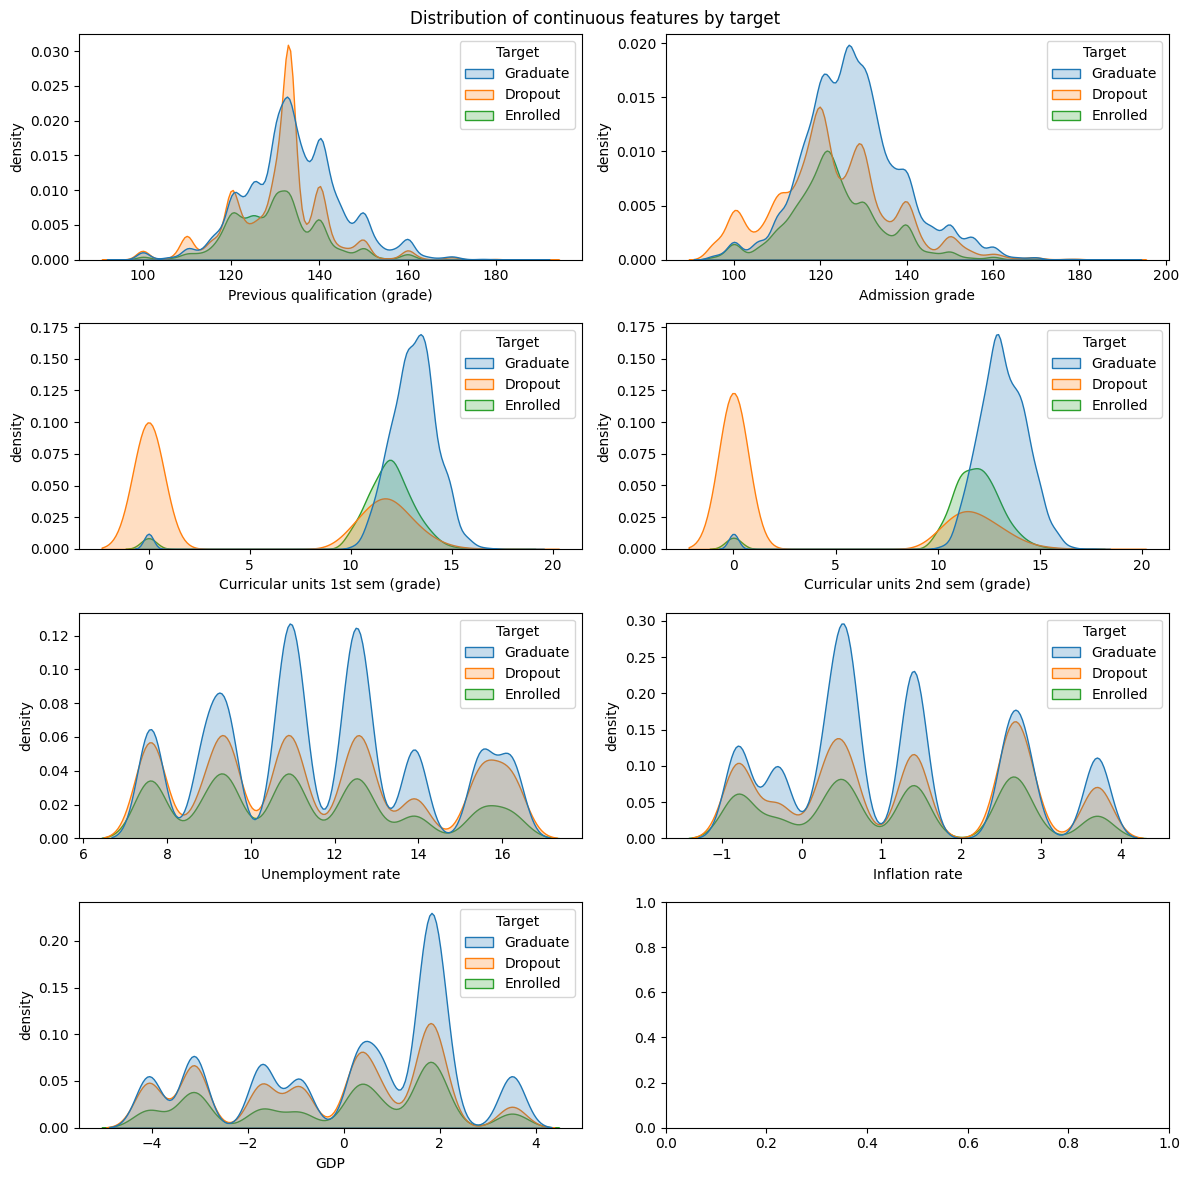

In [24]:
plot_kde_target(df_train, cont_features, fig_size=(12, 12))

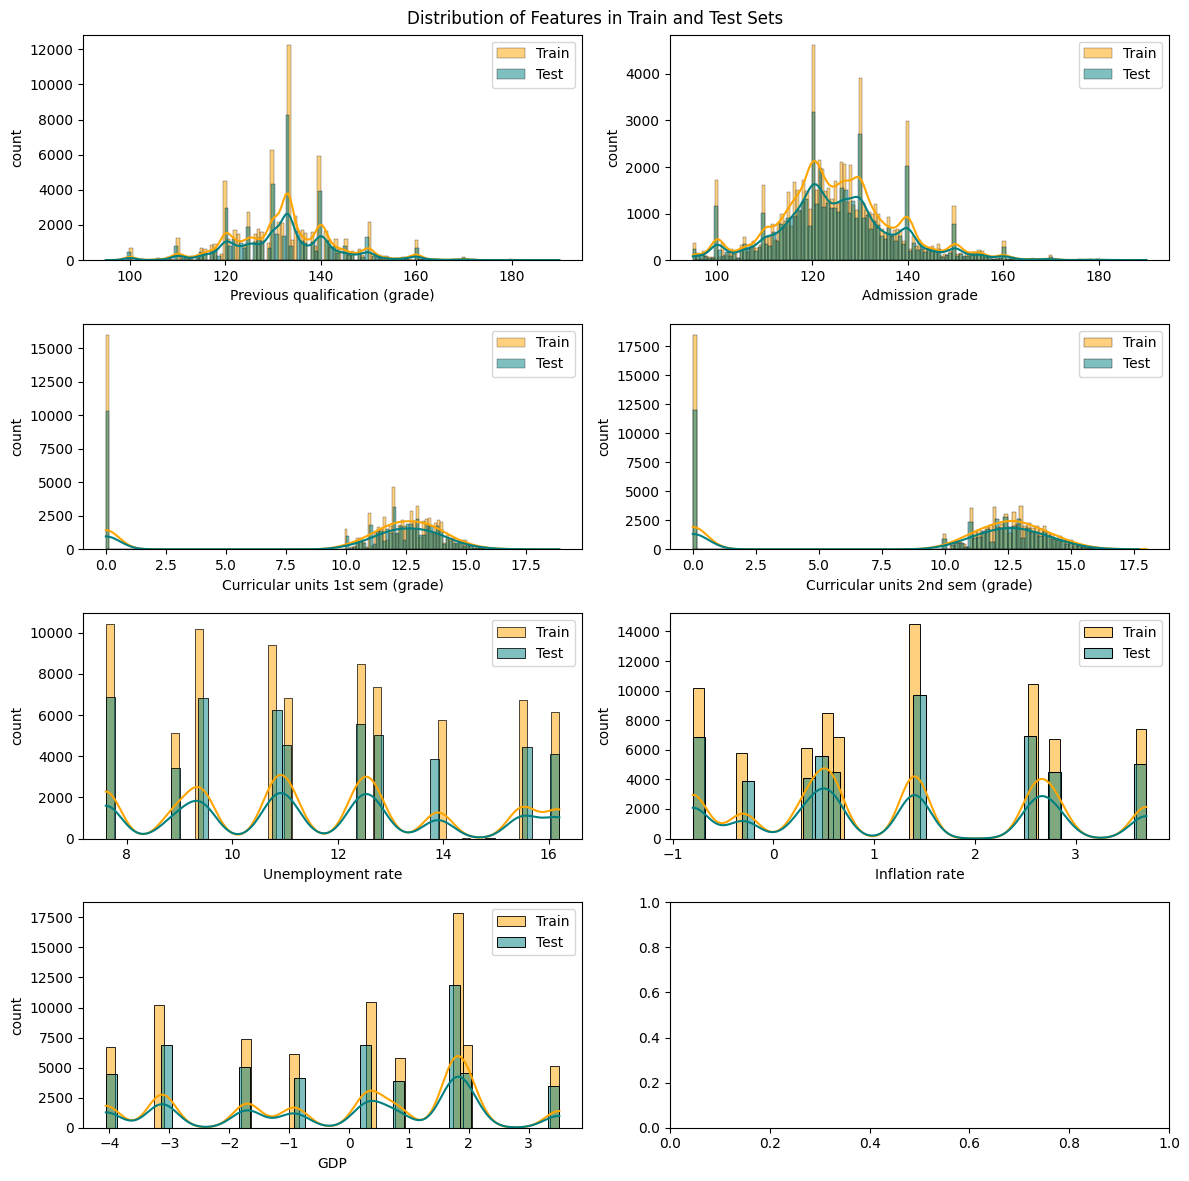

In [19]:
data_utils.plot_feature_distribution(df_train, df_test, cont_features, fig_size=(12, 12))

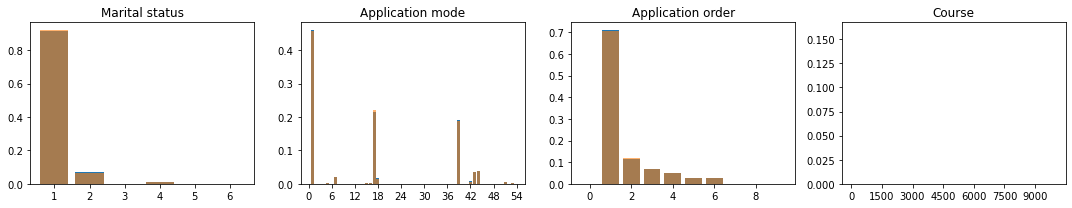

In [ ]:
from matplotlib.ticker import MaxNLocator

initial_features = cat_features[:4]

_, axs = plt.subplots(1, 4, figsize=(15, 3))
for col, ax in zip(initial_features, axs.ravel()):
    vc = df_train[col].value_counts() / len(df_train)
    ax.bar(vc.index, vc)
    vc = df_test[col].value_counts() / len(df_test)
    ax.bar(vc.index, vc, alpha=0.6)
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.tight_layout()
plt.show()